O [AVC -  Acidente Vascular Cerebral](https://www.gov.br/saude/pt-br/assuntos/saude-de-a-a-z/a/avc), acontece quando vasos que levam sangue ao cérebro entopem ou se rompem, provocando a paralisia da área cerebral que ficou sem circulação sanguínea. É uma doença que acomete mais os homens e é uma das principais causas de morte, incapacitação e internações em todo o mundo.

---
AVC Infantil - O AVC infantil é muito comum, alguns anos atrás, esse tipo de situação era visto como paralisia cerebral. No entanto, a paralisia ocorre por falta de oxigenação cerebral, o AVC acontece quando há “entupimento” ou obstrução de um vaso que leva sangue e oxigênio para o cérebro. Infelizmente o [AVC também atinge crianças](https://drauziovarella.uol.com.br/pediatria/avc-tambem-atinge-criancas-principalmente-as-recem-nascidas/#:~:text=O%20AVC%20(acidente%20vascular%20cerebral,%2C%20principalmente%20as%20rec%C3%A9m%2Dnascidas.).

# Importando as bibliotecas

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
%matplotlib inline

## Carregando os Dados

In [2]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

## Informações dos Dados


In [3]:
print('Tamanho dos dados:',df.shape)
print('Dados Duplicados:', df.duplicated().sum())

info_data = pd.DataFrame({
    'Unique':df.nunique(),
    'Null':df.isna().sum(),
    'NullPercent':round(df.isna().sum() / len(df)*100),
    'Type':df.dtypes.values
})
info_data

Tamanho dos dados: (5110, 12)
Dados Duplicados: 0


,Unique,Null,NullPercent,Type
id,5110,0,0.0,int64
gender,3,0,0.0,object
age,104,0,0.0,float64
hypertension,2,0,0.0,int64
heart_disease,2,0,0.0,int64
ever_married,2,0,0.0,object
work_type,5,0,0.0,object
Residence_type,2,0,0.0,object
avg_glucose_level,3979,0,0.0,float64
bmi,418,201,4.0,float64


- Observado a tabela, a coluna de BMI contém 201 dados faltantes. Quando chegar na parte de treinamento irei transformar está coluna utilizando o metódo de imputação. Mas no momento, estarei apenas visualizando os colunas graficamente.

In [4]:
df = df[df['gender'] != 'Other']

In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Transformando os Dados
- Antes de jogar os dados nos modelos de classificação, temos que transformar a coluna de BMI, pois ela contém 201 valores ausentes, e para reaproveitar está coluna irei usar o método de imputação que é uma técnica de preencher os dados faltantes com valores plausíveis. Vou utilizar o método SimpleImputer da scikit-learn para isso.

In [6]:
# modificando o tipo da coluna idade
df['age'] = df['age'].astype(int)

In [7]:
# verificando as idades
df['age'].unique()

array([67, 61, 80, 49, 79, 81, 74, 69, 59, 78, 54, 50, 64, 75, 60, 57, 71,
       52, 82, 65, 58, 42, 48, 72, 63, 76, 39, 77, 73, 56, 45, 70, 66, 51,
       43, 68, 47, 53, 38, 55,  1, 46, 32, 14,  3,  8, 37, 40, 35, 20, 44,
       25, 27, 23, 17, 13,  4, 16, 22, 30, 29, 11, 21, 18, 33, 24, 34, 36,
        0, 41,  5, 26, 31,  7, 12, 62,  2,  9, 15, 28, 10, 19,  6])

In [8]:
cat = df.select_dtypes(include='O')
cat

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [9]:
# transformando os valores de texto
colunas = cat.columns
for col in colunas:
  df[col] = df[col].apply(lambda text: text.capitalize())

In [10]:
# imputando os dados com os valores médios
impute = SimpleImputer(missing_values=np.nan, strategy='mean')
df['bmi'] = impute.fit_transform(df.bmi.values.reshape(-1,1))
cat = df.select_dtypes(include='O')

# salvando conjunto de dados limpo e transformado
#df.to_csv('stroke_cleaned_categorico.csv',index=None, header=True)

# copiando os dados originais, para a variável data, da qual vou usar para a preparação no treinamento de modelos de classificação
data = pd.get_dummies(df, columns = [col for col in df.columns if col in cat])


# Gráficos

In [11]:
# identificando as colunas com valores únicos abaixo de 5, para usá-los no gráfico de pizza
for i in df.columns:
  if df[i].nunique() <=5:
    print(i)

gender
hypertension
heart_disease
ever_married
work_type
Residence_type
smoking_status
stroke


- Visualizando a porcentagem dos dados de cada coluna no conjunto de dados

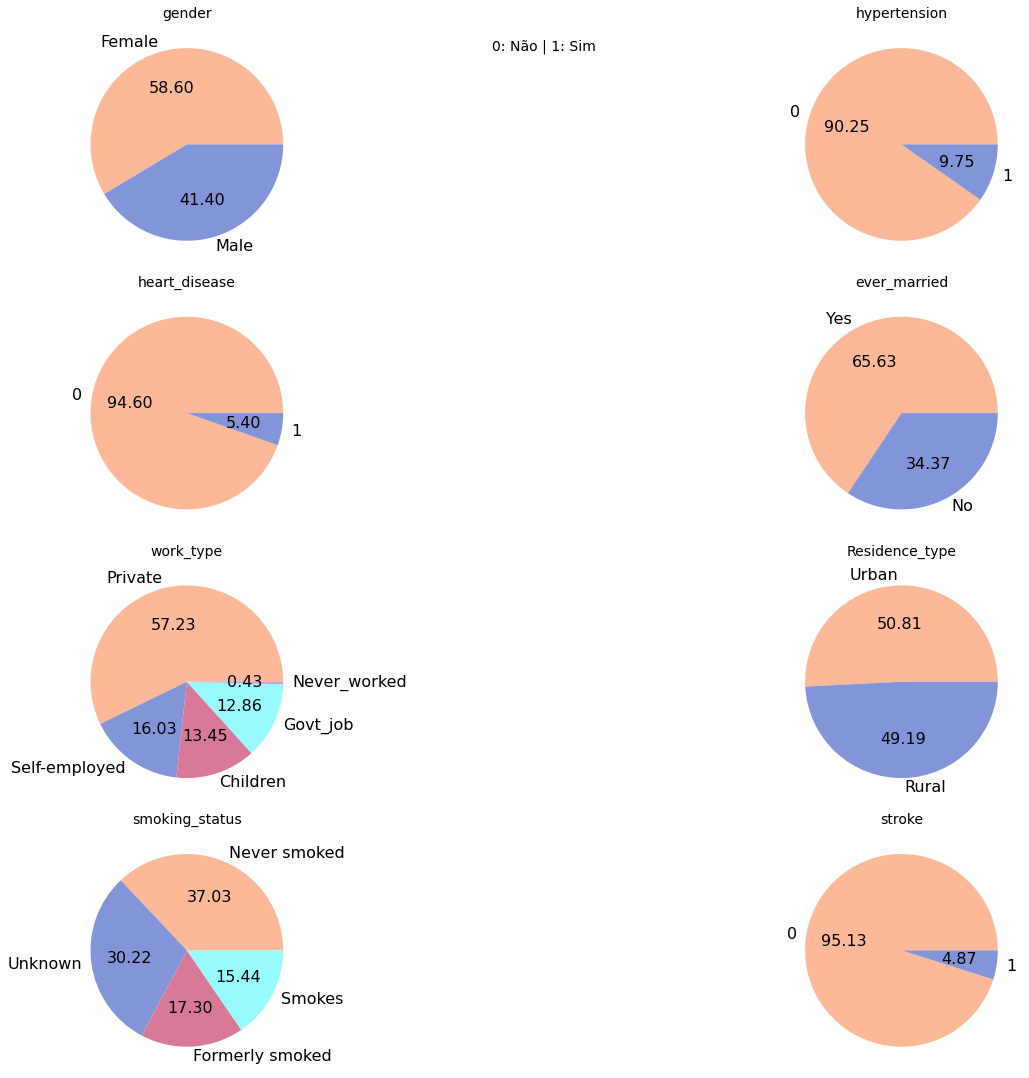

In [55]:
color = ['#FCB897','#8295D9','#D9799A','#97FAFC','#CC9CF0']

colunas = ['gender','hypertension','heart_disease','ever_married',
'work_type','Residence_type','smoking_status','stroke']

plt.figure(figsize=(20,30))
for i, col in enumerate(colunas):
  axes = plt.subplot(8,2, i + 1)
  df[col].value_counts().plot.pie(autopct='%.2f', colors = color, textprops={'size':16})
  plt.suptitle('0: Não | 1: Sim', fontsize=14)
  plt.title(col, fontsize=14)
  plt.axis('off')
plt.tight_layout()
plt.show()

- Podemos ver no gráfico que os dados estão desequilibrados, como a coluna 'Stroke', 'Hypertension', 'Heart Disease'.

- Agora vamos olhar mais de perto os valores únicos de cada coluna.

In [13]:
# selecionando os valores categóricos 
cat = df.select_dtypes(include='O')
for c in cat:
  print('-'*3,c,'-'*3)
  print(df[c].value_counts())
  print()

--- gender ---
Female    2994
Male      2115
Name: gender, dtype: int64

--- ever_married ---
Yes    3353
No     1756
Name: ever_married, dtype: int64

--- work_type ---
Private          2924
Self-employed     819
Children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

--- Residence_type ---
Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

--- smoking_status ---
Never smoked       1892
Unknown            1544
Formerly smoked     884
Smokes              789
Name: smoking_status, dtype: int64



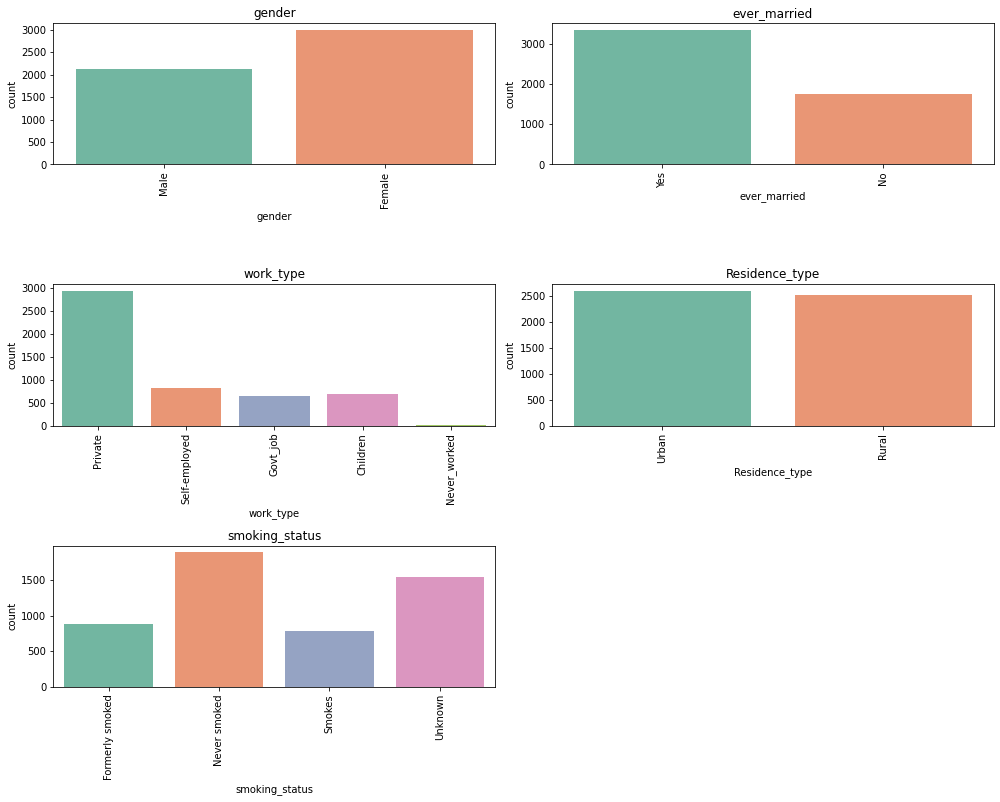

In [14]:
# visualizando a contagem de dados em colunas categóricas
plt.figure(figsize=(14,17))
for i, c in enumerate(cat):
  axes = plt.subplot(5,2, i + 1)
  sns.countplot(x=df[c], ax=axes, palette='Set2')
  plt.xticks(rotation=90);
  plt.title(c, fontsize=12)
plt.tight_layout()
plt.show()

- Vemos que o gênero feminino é maior que o público masculino, porém por ser em maior quantidade nos dados, elas são mais propensas a fumar do que os homens? Por serem em quantidade, as colunas seguintes tem uma forte relações com este gênero? 
- Nos status de Fumante pode-se observar que a maioria das pessoas não fumam, enquanto outros são desconhecido.

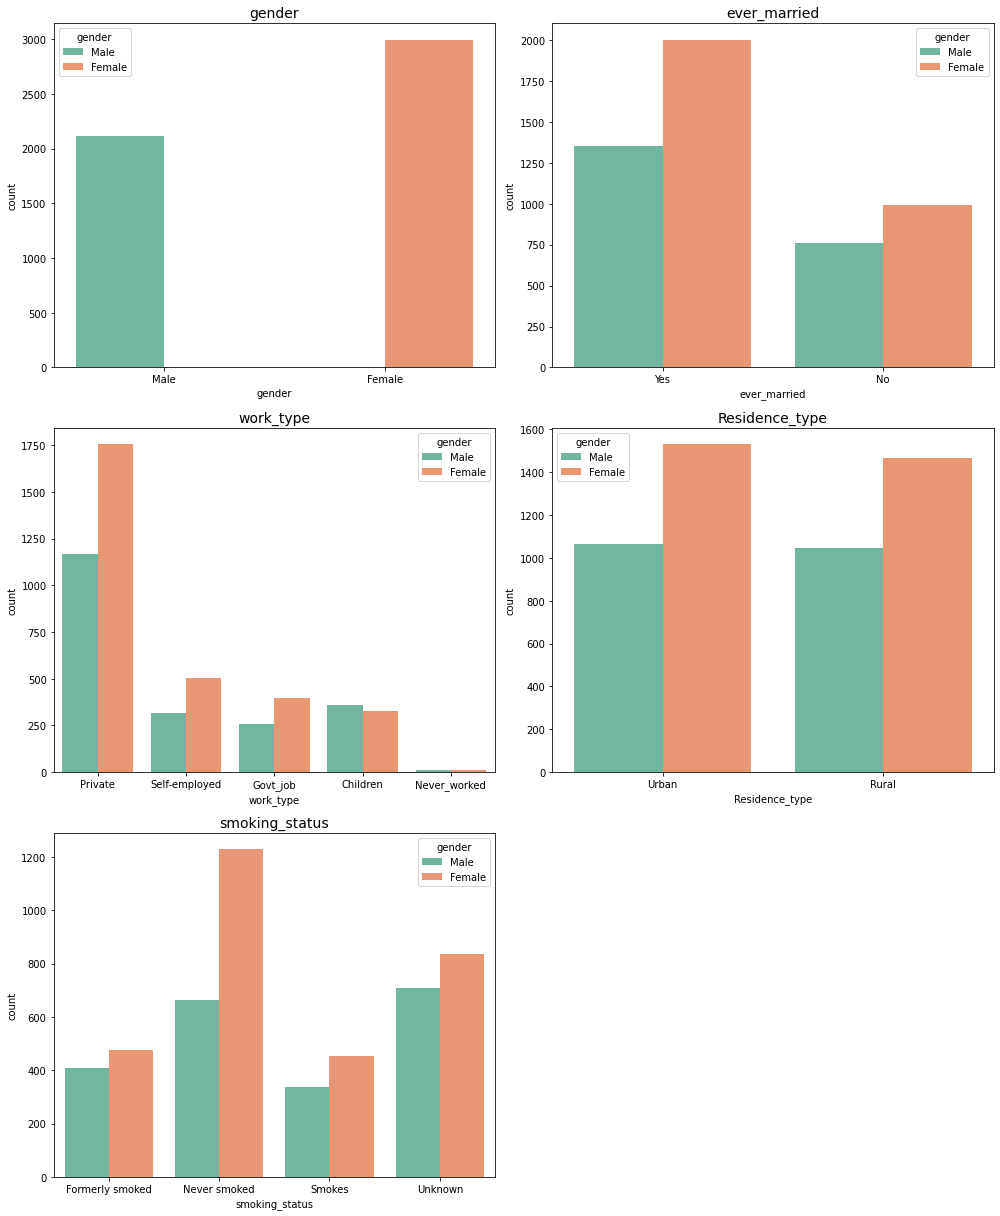

In [15]:
# Qual a relação dos gêneros com outras colunas?
plt.figure(figsize=(14,17))
for i, col in enumerate(cat):
  axes = plt.subplot(3,2, i + 1)
  sns.countplot(x=df[col], hue=df['gender'], ax=axes, palette='Set2')
  plt.title(col, fontsize=14)
plt.tight_layout()
plt.show()

- Respondendo a primeira pergunta, embora os dados apresentem uma quantidade pequena sobre fumantes, as mulheres são mais propensas a fumar e tem grande relação com as outras colunas

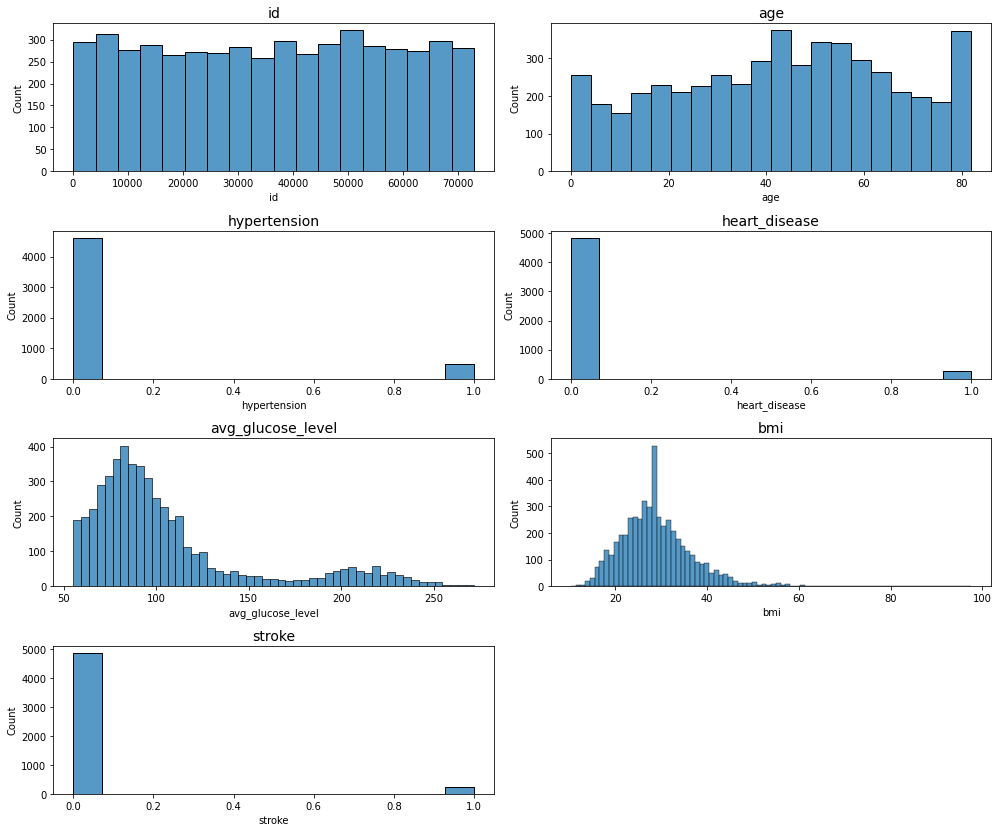

In [16]:
num = df.select_dtypes(exclude='O')

plt.figure(figsize=(14,17))
for i, n in enumerate(num):
  axes = plt.subplot(6,2,i + 1)
  sns.histplot(x=df[n],ax=axes)
  plt.title(n, fontsize=14)
plt.tight_layout()
plt.show()

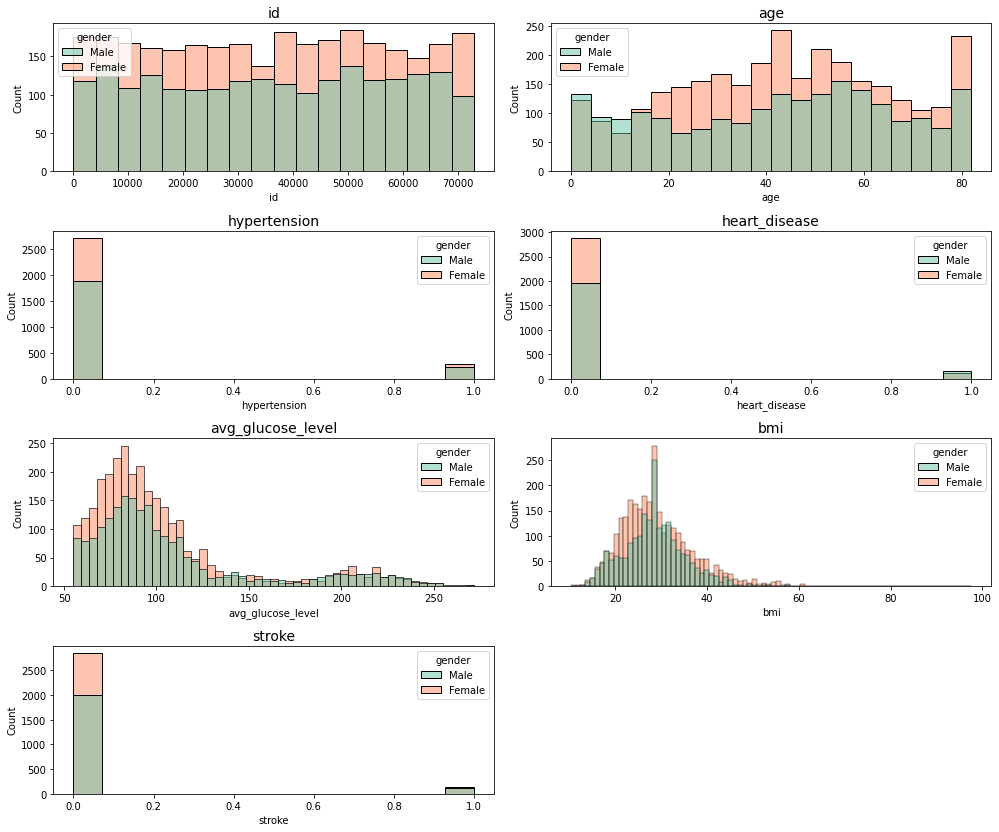

In [17]:
# visualizando qual é o gênero mais frequente com os dados numéricos
plt.figure(figsize=(14,17))
for i, n in enumerate(num):
  axes = plt.subplot(6,2,i + 1)
  sns.histplot(x=df[n], hue=df['gender'],ax=axes, palette='Set2')
  plt.title(n, fontsize=14)
plt.tight_layout()
plt.show()

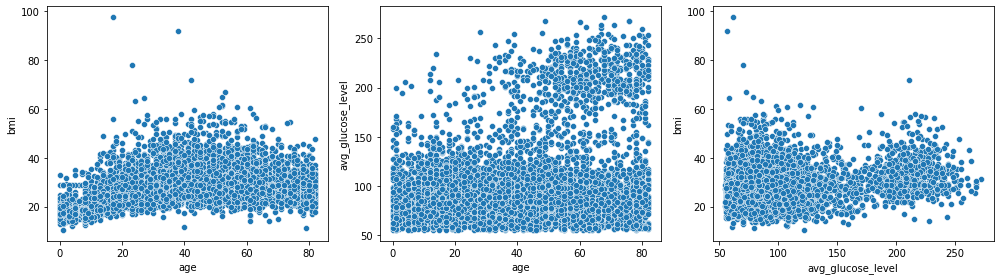

In [18]:
fig, axes = plt.subplots(1,3,figsize=(14,4))
sns.scatterplot(x=df['age'], y=df['bmi'], ax=axes[0])

sns.scatterplot(x=df['age'], y=df['avg_glucose_level'], ax=axes[1])

sns.scatterplot(x=df['avg_glucose_level'], y=df['bmi'], ax=axes[2])

plt.tight_layout()
plt.show()

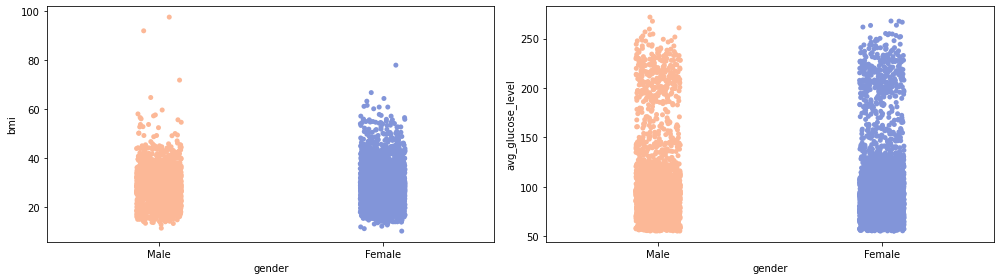

In [19]:
fig,axes = plt.subplots(1,2,figsize=(14,4))
sns.stripplot(x=df['gender'], y=df['bmi'],ax=axes[0], palette=color)
sns.stripplot(x=df['gender'], y=df['avg_glucose_level'],ax=axes[1], palette=color)

plt.tight_layout()
plt.show()

In [20]:
df[df['bmi'] > 70]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,545,Male,42,0,0,Yes,Private,Rural,210.48,71.9,Never smoked,0
928,41097,Female,23,1,0,No,Private,Urban,70.03,78.0,Smokes,0
2128,56420,Male,17,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,51856,Male,38,1,0,Yes,Private,Rural,56.90,92.0,Never smoked,0


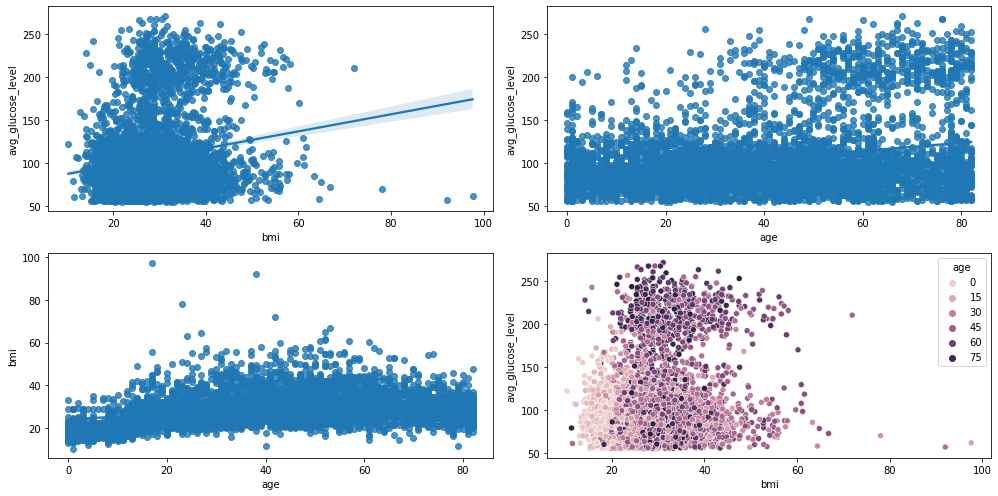

In [21]:
fig, axes = plt.subplots(2,2, figsize=(14,7))
sns.regplot(x=df['bmi'], y=df['avg_glucose_level'], ax=axes[0][0])
sns.regplot(x=df['age'], y=df['avg_glucose_level'], ax=axes[0][1])
sns.regplot(x=df['age'], y=df['bmi'], ax=axes[1][0])
sns.scatterplot(data=df, x='bmi', y='avg_glucose_level', hue='age', ax=axes[1][1])

plt.tight_layout()
plt.show()

## AVC Infantil

In [22]:
infantil = df[df['work_type'] == 'Children']

In [23]:
print(len(df))
print(len(infantil))

5109
687


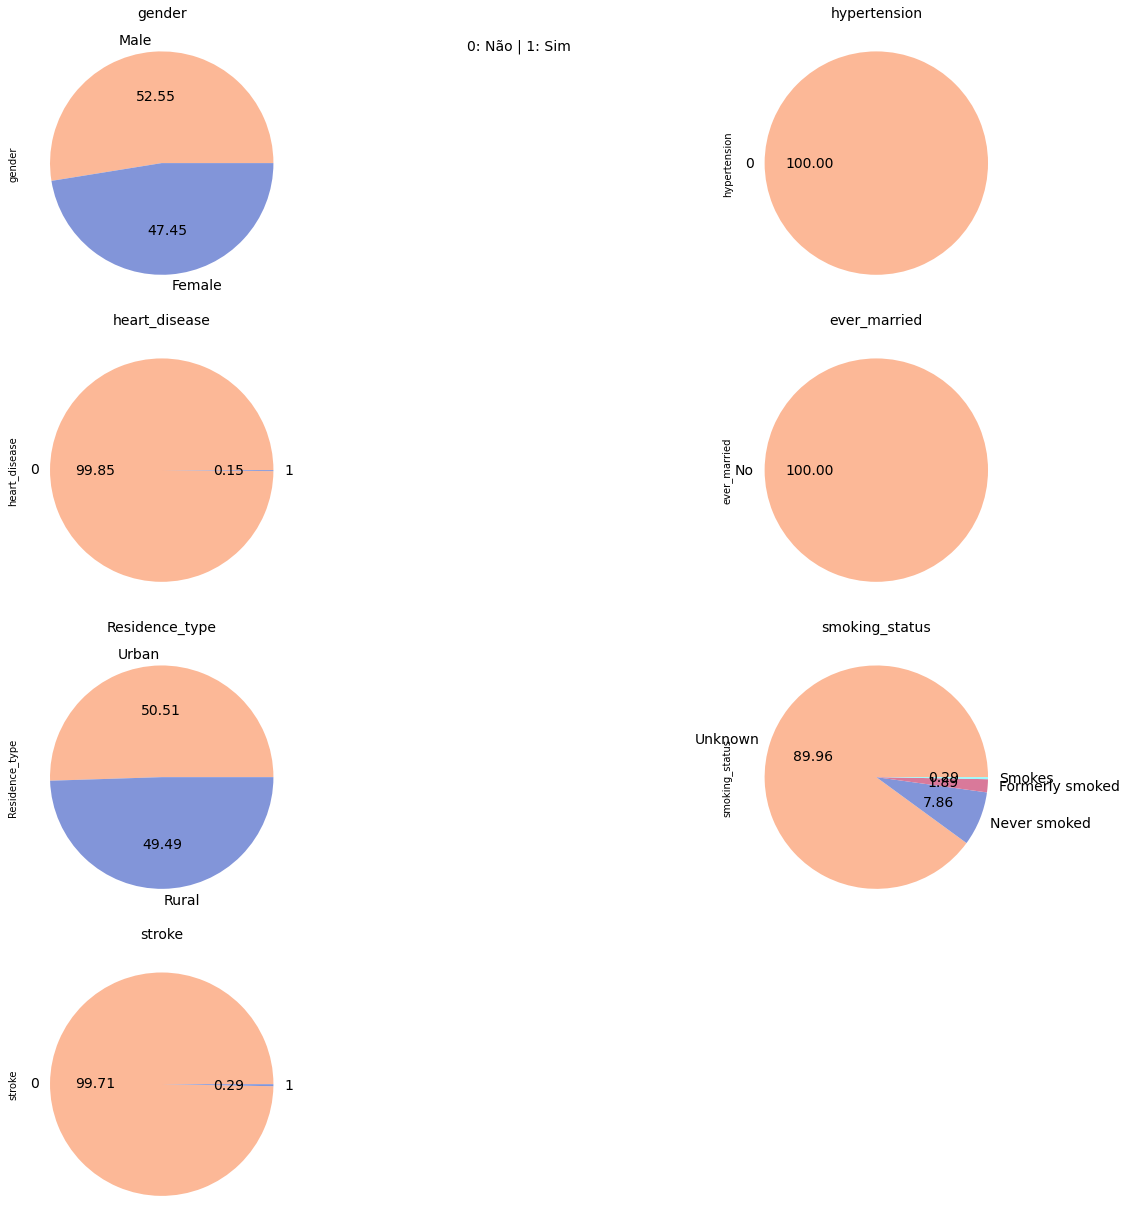

In [24]:
color = ['#FCB897','#8295D9','#D9799A','#97FAFC','#CC9CF0']

colunas = ['gender',
'hypertension',
'heart_disease',
'ever_married',
'Residence_type',
'smoking_status',
'stroke'
]
plt.figure(figsize=(20,30))
for i, col in enumerate(colunas):
  axes = plt.subplot(7,2, i + 1)
  infantil[col].value_counts().plot.pie(autopct='%.2f', colors = color, textprops={'size':14})
  plt.suptitle('0: Não | 1: Sim', fontsize=14)
  plt.title(col, fontsize=14)
plt.tight_layout()
plt.show()

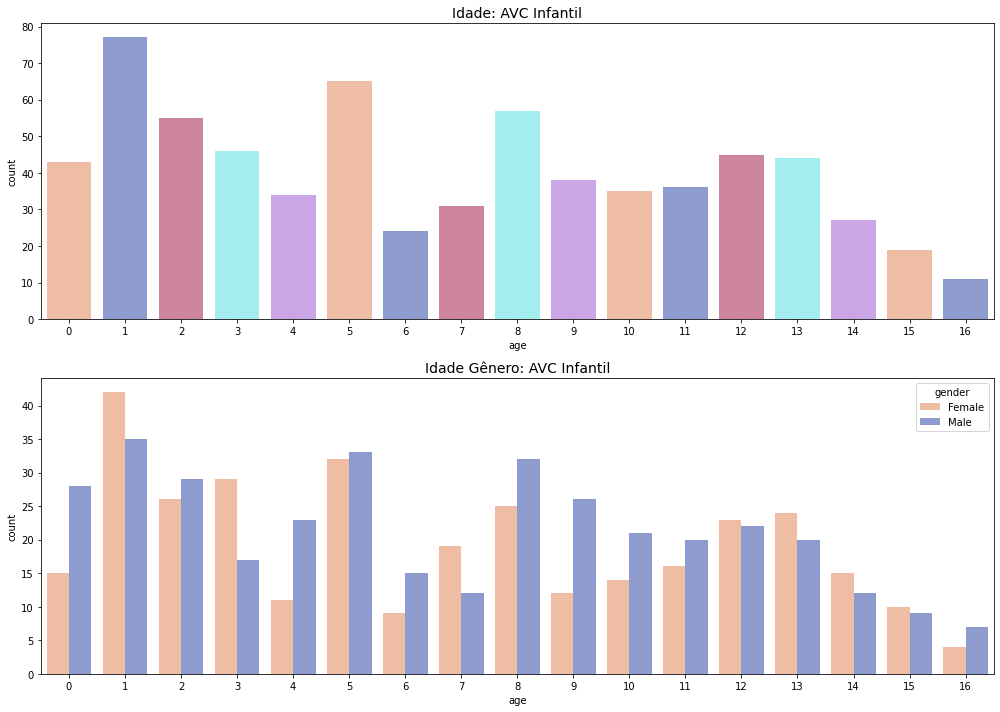

In [25]:
fig, axes = plt.subplots(2,1,figsize=(14,10))

axes[0].set_title('Idade: AVC Infantil', fontsize=14)
sns.countplot(x = infantil['age'], palette=color, ax=axes[0])

axes[1].set_title('Idade Gênero: AVC Infantil', fontsize=14)
sns.countplot(x = infantil['age'], hue=infantil['gender'], palette=['#FCB897','#8295D9'], ax=axes[1])

plt.tight_layout()
plt.show()

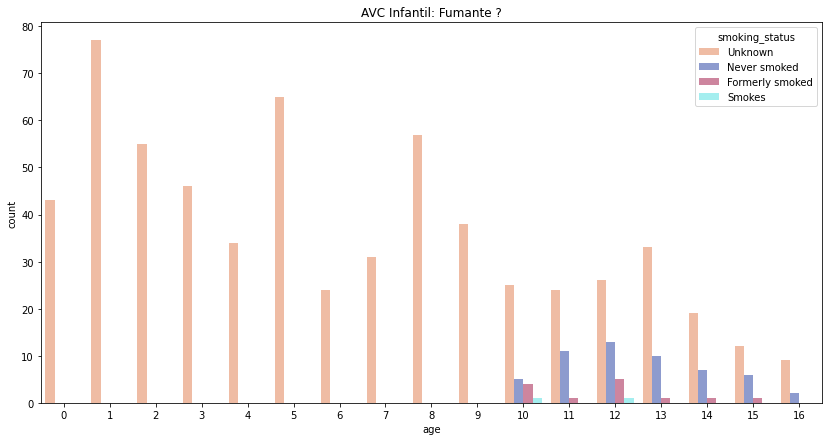

In [26]:
plt.figure(figsize=(14,7))
plt.title('AVC Infantil: Fumante ?')
sns.countplot(x=infantil['age'], hue=infantil['smoking_status'], palette=color)

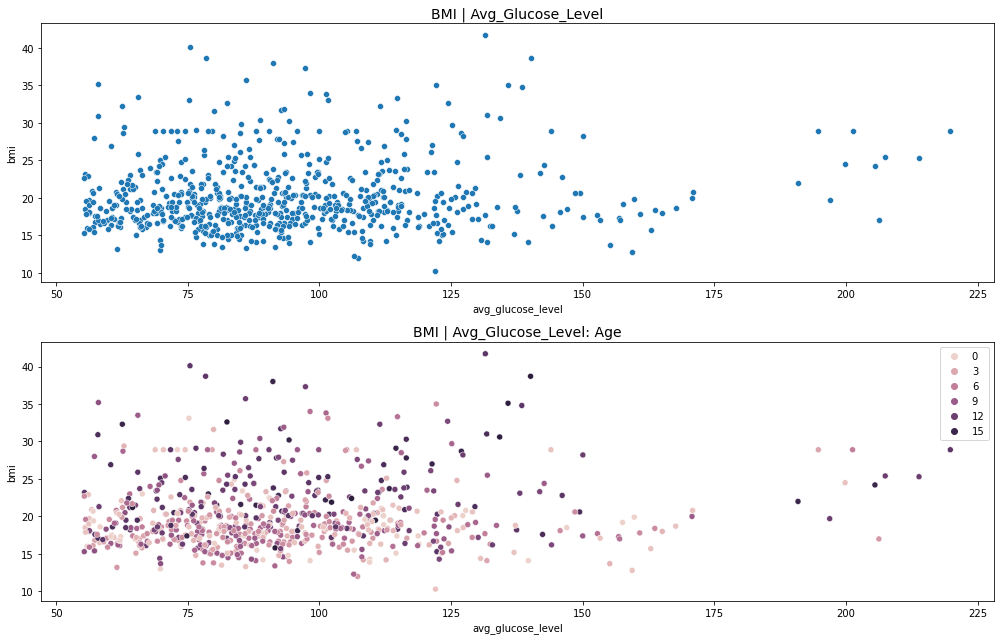

In [27]:
fig, axes =  plt.subplots(2,1,figsize=(14,9))

axes[0].set_title('BMI | Avg_Glucose_Level', fontsize=14)
sns.scatterplot(x=infantil['avg_glucose_level'], y=infantil['bmi'], ax=axes[0])

axes[1].set_title('BMI | Avg_Glucose_Level: Age', fontsize=14)
sns.scatterplot(x=infantil['avg_glucose_level'], y=infantil['bmi'], hue=infantil['age'], ax=axes[1])

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [28]:
infantil.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1,0,0,No,Children,Urban,70.37,28.89456,Unknown,1
245,49669,Female,14,0,0,No,Children,Rural,57.93,30.90000,Unknown,1
249,30669,Male,3,0,0,No,Children,Rural,95.12,18.00000,Unknown,0
282,33759,Female,3,0,0,No,Children,Urban,73.74,16.00000,Unknown,0
290,55680,Male,13,0,0,No,Children,Urban,114.84,18.30000,Unknown,0


# Preparação dos Dados

### Separando os dados

In [29]:
# separando as features e a classe
y = data.stroke
x = data.drop(['stroke'], axis=1).values
x_columns = data.drop(['stroke'], axis=1)

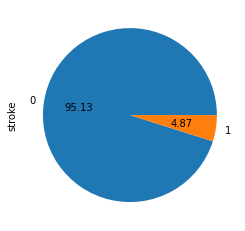

In [30]:
y.value_counts().plot.pie(autopct='%.2f')

### Balanceando os dados

- Com os dados desbalanceados, usarei o método SMOTE, ele gera novas instâncias de casos minoritários existentes quando fornece como entrada.
??????

In [31]:
# dados desbalanceados
sm = SMOTE(sampling_strategy='auto',random_state=42) 
x, y = sm.fit_resample(x, y)

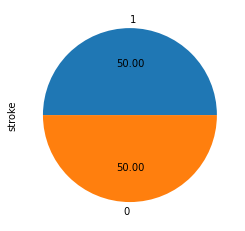

In [32]:
y.value_counts().plot.pie(autopct='%.2f')

### Separando os dados para treino e teste

In [33]:
# separando os daods para treino e teste
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3, random_state=42)

### Modelo Random Forest

In [34]:
# features de importance
forest = RandomForestClassifier(n_estimators= 300,max_depth=6, random_state=42)
forest.fit(xtrain, ytrain)
forest.score(xtest, ytest)

0.9465020576131687

In [35]:
# Visualizando os features com mais importância no conjunto de treino
result = pd.Series(forest.feature_importances_, index=x_columns.columns).sort_values(ascending=False)
print(result)

age                               2.539829e-01
ever_married_Yes                  8.634878e-02
ever_married_No                   8.548158e-02
hypertension                      7.857567e-02
heart_disease                     6.211327e-02
work_type_Private                 5.401683e-02
Residence_type_Rural              5.241518e-02
smoking_status_Never smoked       4.583073e-02
Residence_type_Urban              3.953400e-02
work_type_Self-employed           3.899346e-02
smoking_status_Unknown            3.881296e-02
gender_Male                       3.355428e-02
smoking_status_Formerly smoked    3.298541e-02
gender_Female                     2.717432e-02
avg_glucose_level                 2.148936e-02
smoking_status_Smokes             2.068533e-02
work_type_Govt_job                1.193454e-02
id                                7.880228e-03
bmi                               6.202947e-03
work_type_Children                1.987904e-03
work_type_Never_worked            3.315955e-07
dtype: float6

In [36]:
# encontrado o melhor parâmetros
param_grid = {
    'max_depth':[2,3,4,5,6,7,8],
    'max_features':[2,3],
    'n_estimators':[50,70,100,200,300]
}

grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=4, n_jobs=-1,verbose=2)

grid_search.fit(xtrain, ytrain)

# o melhor parâmetro
grid_search.best_params_

Fitting 4 folds for each of 70 candidates, totalling 280 fits


{'max_depth': 8, 'max_features': 3, 'n_estimators': 300}

In [37]:
# o melhor estimador
grid_search.best_estimator_

RandomForestClassifier(max_depth=8, max_features=3, n_estimators=300,
                       random_state=42)

In [38]:
# adicionando os parâmetros no modelo Random Forest
forest = RandomForestClassifier(max_depth=8, max_features=3, n_estimators=300,
                       random_state=42)
forest.fit(xtrain,ytrain)

print('Train Score:', forest.score(xtrain, ytrain))
print('Test Score:',forest.score(xtest,ytest))

print('Classification Report:')
print(classification_report(ytest, forest.predict(xtest)))

Train Score: 0.9747207524985303
Test Score: 0.9554183813443072
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1458
           1       0.99      0.92      0.95      1458

    accuracy                           0.96      2916
   macro avg       0.96      0.96      0.96      2916
weighted avg       0.96      0.96      0.96      2916



In [39]:
# matrix de confusão
cm = confusion_matrix(ytest, forest.predict(xtest))

# porcentagem das classes na matrix de confusão
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
cm_norm

array([[0.98834019, 0.01165981],
       [0.07750343, 0.92249657]])

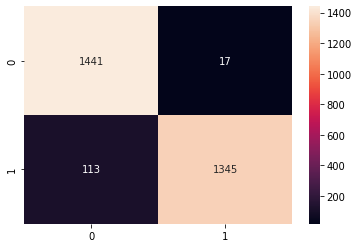

In [40]:
sns.heatmap(cm, annot=True, fmt='d')

- O Modelo conseguiu acerta 1383 da classe 1 e 1436 da classe 0.

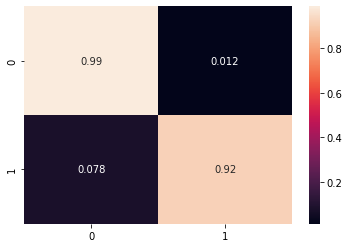

In [41]:
sns.heatmap(cm_norm, annot=True)

- O modelo acertou 93% dos dados da classe 1 como sendo certo, e acertou 99% dos dados da classe 0 como verdadeiros. 

- No primeiro treinamento com o Random Forest ele deu como resultado 94% de acurácia, depois de utilizar O GridSearch e encontrar o melhor parâmetro para o modelo da Random Forest, arredondando o resultado foi dado 96% de acúracia.

## Modelo Gradient

- Vou utilizar dos mesmo código feito com o Random Forest no modelo Gradient Boosting e verificar se há alguma diferença e melhora no resultado.

In [42]:
# Retirando duas features dadas como não importante no conjunto de treino
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3, random_state=42)

In [43]:
print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)

(6804, 21) (2916, 21)
(6804,) (2916,)


In [44]:
grade = GradientBoostingClassifier(random_state=42)

grade.fit(xtrain,ytrain)
grade.score(xtest,ytest)

0.9588477366255144

In [45]:
# Adicionando os mesmo parâmetros do modelo anterior
params = {
    'max_depth':[2,3,4,5,6,7,8],
    'max_features':[2,3],
    'n_estimators':[50,70,100,200,300]
}

grid_search = GridSearchCV(estimator=grade, param_grid=params, cv=4, n_jobs=-1)

grid_search.fit(xtrain,ytrain)

grid_search.best_params_

{'max_depth': 7, 'max_features': 3, 'n_estimators': 200}

In [46]:
grade = GradientBoostingClassifier(max_depth=8, n_estimators=200, max_features=3, random_state=42)
grade.fit(xtrain,ytrain)

y_pred = grade.predict(xtrain)
y_pred_t = grade.predict(xtest)

print('Train Score:',grade.score(xtrain, ytrain))
print('Test Score:',grade.score(xtest, ytest))

print('Classification Report')
print(classification_report(ytest, grade.predict(xtest)))

Train Score: 1.0
Test Score: 0.9698216735253772
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1458
           1       0.99      0.95      0.97      1458

    accuracy                           0.97      2916
   macro avg       0.97      0.97      0.97      2916
weighted avg       0.97      0.97      0.97      2916



- No modelo anterior do Gradient a acúracia foi de 95%, agora utilizando o GridSearch para encontrar o melhor parâmetro, o resultado foi de 97%. Em comparação entre o Gradient Boosting e Random Forest utilizando dos mesmo parâmetros, o Gradient foi o melhor.

In [47]:
# Matrix de Confusão
cm = confusion_matrix(ytest, grade.predict(xtest))

# Visualizando a porcentagem através da matrix
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

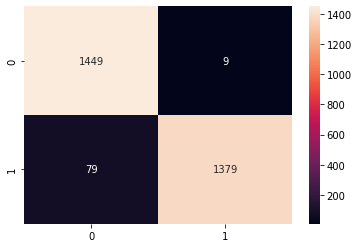

In [48]:
# imprimindo o resultado 
sns.heatmap(cm, annot=True, fmt='d')

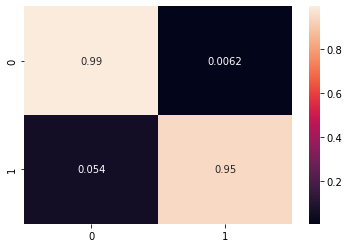

In [49]:
sns.heatmap(cm_norm, annot=True)

- O modelo acertou 94% dos dados da classe 1 como sendo certo, e acertou 99% dos dados da classe 0 como verdadeiros. 

## Salvando o modelo

In [ ]:
#pickle.dump(, open('grade_clf.pkl','wb'))
